In [85]:
from scripts.readers import read_images, read_image, save_TIFF

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import porespy as ps
import importlib as il
import os

from scipy.stats import wilcoxon, ks_2samp, f_oneway, entropy
from scipy.ndimage import distance_transform_edt
from scipy.spatial.distance import directed_hausdorff
from skimage.io import imread
from skimage.measure import regionprops, regionprops_table, shannon_entropy
from skimage.metrics import hausdorff_distance
from sklearn.metrics import roc_curve, auc, jaccard_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from collections import OrderedDict
from importlib.metadata import version
from itertools import combinations

In [2]:
segment_kmeans_clust = il.import_module("segment.kmeans_clust")
segment_extract_pores = il.import_module("segment.extract_pores")
segment_process_segments = il.import_module("segment.process_segments")
segment_distance_thickness = il.import_module("segment.distance_thickness")

pores_pore_network = il.import_module("pores.pore_network")
pores_pore_regionprops = il.import_module("pores.pore_regionprops")
pores_pore_metric_test = il.import_module("pores.pore_metric_test")
pores_rdd_psd_dist_comparison = il.import_module("pores.rdd_psd_dist_comparison")

plots_plots_3d = il.import_module("plots.plots_3d")
plots_colormaps_lec = il.import_module("plots.colormaps_lec")

In [3]:
segment_kmeans_clust = il.reload(segment_kmeans_clust)
segment_extract_pores = il.reload(segment_extract_pores)
segment_process_segments = il.reload(segment_process_segments)
segment_distance_thickness = il.reload(segment_distance_thickness)

pores_pore_network = il.reload(pores_pore_network)
pores_pore_regionprops = il.reload(pores_pore_regionprops)
pores_pore_metric_test = il.reload(pores_pore_metric_test)
pores_rdd_psd_dist_comparison = il.reload(pores_rdd_psd_dist_comparison)

plots_plots_3d = il.reload(plots_plots_3d)
plots_colormaps_lec = il.reload(plots_colormaps_lec)

In [4]:
# Store size and rdd distributions
psd_vx_log_dict_pdf = {}
psd_vx_log_dict_cdf = {}

rdd_vx_log_dict_pdf = {}
rdd_vx_log_dict_cdf = {}

In [45]:
psd_vx_log_dict_pdf_upper = {}
psd_vx_log_dict_cdf_upper = {}

rdd_vx_log_dict_pdf_upper = {}
rdd_vx_log_dict_cdf_upper = {}

psd_vx_log_dict_pdf_lower = {}
psd_vx_log_dict_cdf_lower = {}

rdd_vx_log_dict_pdf_lower = {}
rdd_vx_log_dict_cdf_lower = {}

In [62]:
# NOTE: Need to implement False
load_single = True # If False, will load all specified bread samples as a list
load_original = True # If False, the original sample image will not be loaded
vx_size = 60.9e-6 # Voxel size in metres
invert_flag = 0 # Flag to determine whether inverted_image_1 was saved or not

In [63]:
if load_single:
    # start_indices = [150, 299, 180, 300]; start_indices2 = [1420, 1440, 1420, 1440]
    # end_indices = [799, 853, 829, 899]; end_indices2 = [2069, 1994, 2069, 2039]
    # bread_types = ["Ro1a", "Ru1a", "V1a", "W1a"]
    
    start_idx = 1440
    end_idx = 1994
    bread_type = 'Ru1a'
    #save_slice_num = str(int(end_idx-start_idx+1))
    # FIX: automatic slicenum detection
    if bread_type == 'Ro1a':
        save_slice_num = "650"
    elif bread_type == 'Ru1a':
        save_slice_num = "555"
    elif bread_type == 'V1a':
        save_slice_num = "650"
    elif bread_type == 'W1a':
        save_slice_num = "600"
    else:
        print('Check Bread Type')
    output_path = '/cluster/scratch/spruthi/qbi2024_project/'+bread_type+'_save_'+save_slice_num
    if os.path.exists(output_path):
        print('Starting')
    else:
        print('Target path created, check '+output_path)
        os.makedirs(output_path, exist_ok=True)
        # FIX: Need to fix the path
        print('You may want to manually specify save_slice_num')

Starting


In [64]:
if load_single:
    # Load stored images

    # Bread structure (pores = 0)
    connthresh_medfilter3_ds_img_1 = read_images(os.path.join(output_path, (bread_type+'_connthresh_medfilter3_ds_img_1_{0:04}.tif')), start_idx, end_idx)
    print(connthresh_medfilter3_ds_img_1.shape)

    # Filled bread (solid structure)
    filled_pores_1 = read_images(os.path.join(output_path, (bread_type+'_filled_pores_1_{0:04}.tif')), start_idx, end_idx)

    # Pores segmented based on connected components labelling
    merged_labelled_image_lbl = read_images(os.path.join(output_path, (bread_type+'_merged_labelled_image_lbl_{0:04}.tif')), start_idx, end_idx)

    # Pores segmented based on watershed analysis
    merged_labelled_image_ws = read_images(os.path.join(output_path, (bread_type+'_merged_labelled_image_ws_{0:04}.tif')), start_idx, end_idx)

    # Local thicnkess map of pores generated using porespy
    lt_ws = read_images(os.path.join(output_path, (bread_type+'_lt_ws_{0:04}.tif')), start_idx, end_idx)
    
    # Inverted image - extracted pores (if exists)
    if os.path.isfile(os.path.join(output_path, (bread_type+'_inverted_image_1_'+str(start_idx)+'.tif'))):
        inverted_image_1 = read_images(os.path.join(output_path, (bread_type+'_inverted_image_1_{0:04}.tif')), start_idx, end_idx)
        invert_flag = 1
        print('Inverted image loaded')
        
    # Original Image
    if load_original:
        img = img = read_images('/cluster/scratch/spruthi/qbi2024_project/'+bread_type+'/'+bread_type+'_0{0:04}.tif', start_idx, end_idx)
        img = img[:,150:1350,150:1350]
        
    # Loading metrics (if needed)
    #df_pair_pore = pd.read_pickle(os.path.join(output_path, (bread_type+'_df_pair_pore.pkl')))
    #df_pair_pore2 = pd.read_pickle(os.path.join(output_path, (bread_type+'_df_pair_pore2.pkl')))

  0%|          | 0/555 [00:00<?, ?it/s]

(555, 1200, 1200)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

Inverted image loaded


  0%|          | 0/555 [00:00<?, ?it/s]

In [50]:
# Compare segmentations - Jaccard index, Dice, Hausdorff distance
# Radial density distribution (and pore size distribution)
# Pipeline at a glance
# Montage pad - show
# 3d plot of image volume
# Network - porespy and custom

In [51]:
# img
# connthresh_medfilter3_ds_img_1
# filled_pores_1
# inverted_image_1
# merged_labelled_image_lbl
# merged_labelled_image_ws
# lt_ws

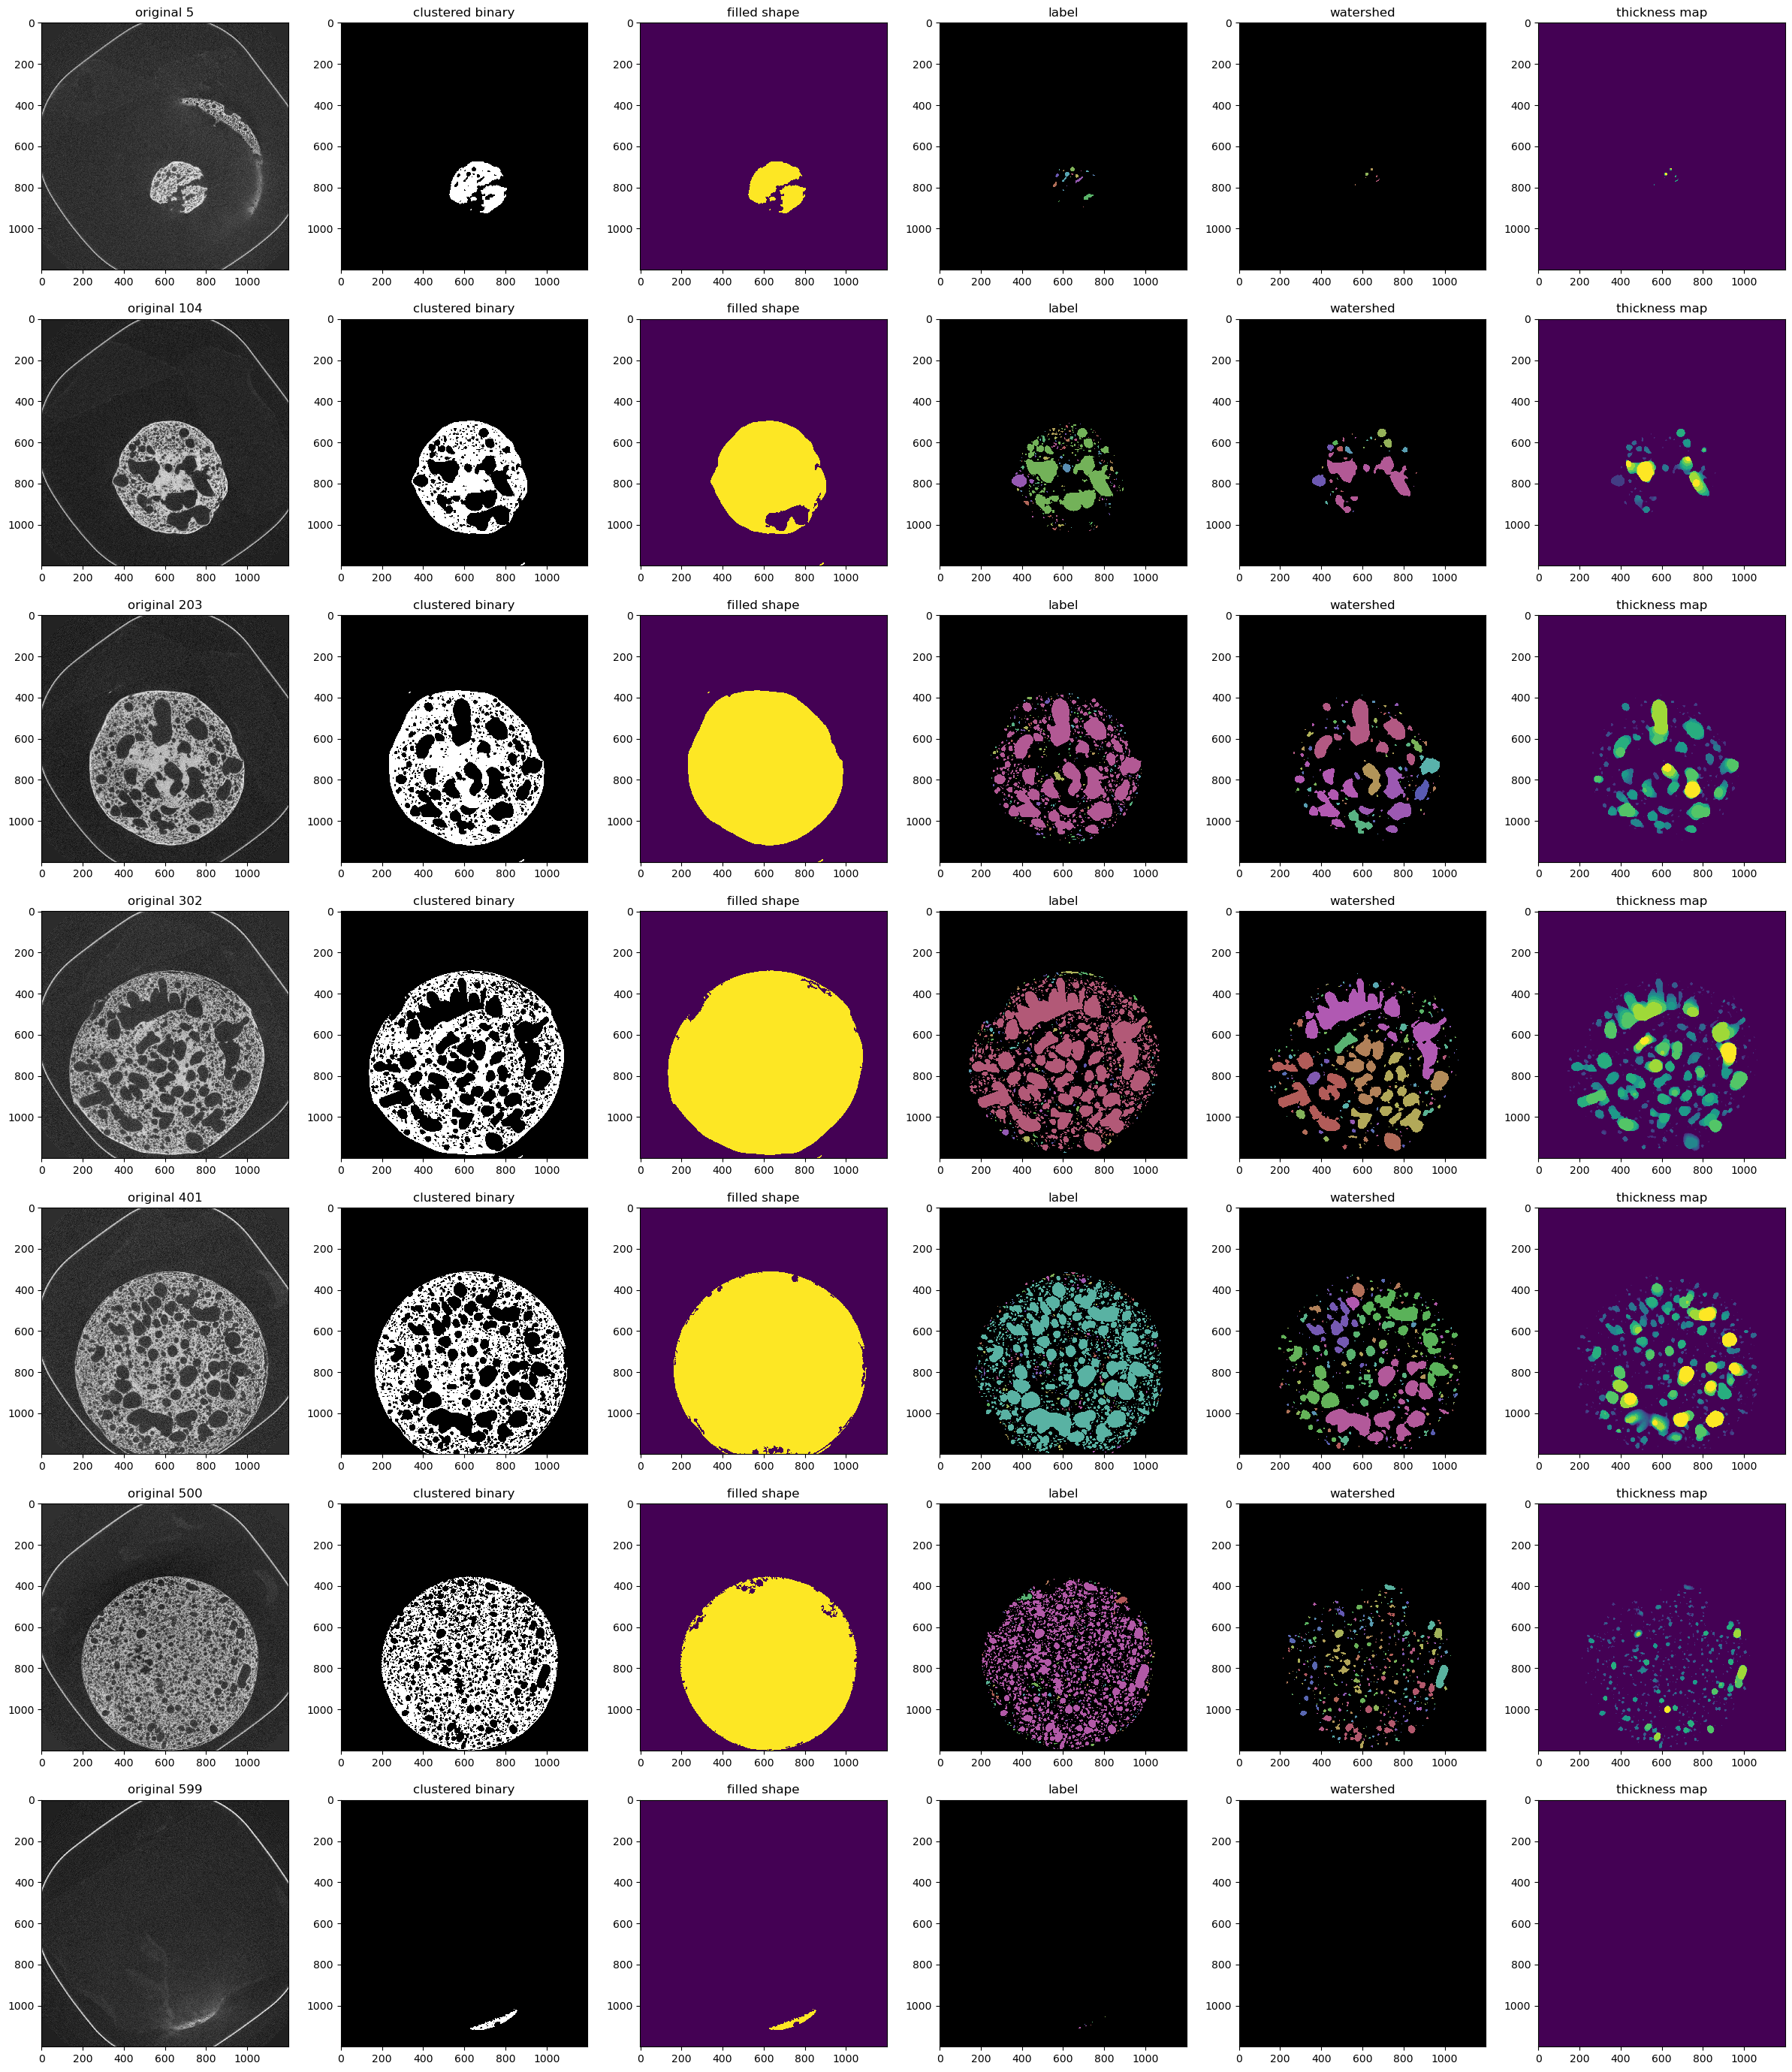

In [86]:
# Pipeline at a glance
goldenCM = getattr(plots_colormaps_lec,"goldenCM")
img_sample = 5
if invert_flag == 1:
    fig, ax = plt.subplots(7,7,figsize=(35,35))

    for i in range(7):
        cur_img_sample = img_sample + i*88
        ax[i,0].imshow(img[cur_img_sample], interpolation='none', cmap='gray'); ax[i,0].set_title(f'original {cur_img_sample}')
        ax[i,1].imshow(connthresh_medfilter3_ds_img_1[cur_img_sample], interpolation='none', cmap='gray'); ax[i,1].set_title('clustered binary')
        ax[i,2].imshow(filled_pores_1[cur_img_sample], interpolation='none', cmap='viridis'); ax[i,2].set_title('filled shape')
        ax[i,3].imshow(inverted_image_1[cur_img_sample], interpolation='none', cmap='viridis'); ax[i,3].set_title('extracted pores')
        ax[i,4].imshow(merged_labelled_image_lbl[cur_img_sample], interpolation='none', cmap=goldenCM(int(merged_labelled_image_lbl.max()))); ax[i,4].set_title('label')
        ax[i,5].imshow(merged_labelled_image_ws[cur_img_sample], interpolation='none', cmap=goldenCM(int(merged_labelled_image_ws.max()))); ax[i,5].set_title('watershed')
        ax[i,6].imshow(lt_ws[cur_img_sample], interpolation='none', cmap='viridis'); ax[i,6].set_title('thickness map')
else:
    fig, ax = plt.subplots(7,6,figsize=(30,35))

    for i in range(7):
        cur_img_sample = img_sample + i*99
        ax[i,0].imshow(img[cur_img_sample], interpolation='none', cmap='gray'); ax[i,0].set_title(f'original {cur_img_sample}')
        ax[i,1].imshow(connthresh_medfilter3_ds_img_1[cur_img_sample], interpolation='none', cmap='gray'); ax[i,1].set_title('clustered binary')
        ax[i,2].imshow(filled_pores_1[cur_img_sample], interpolation='none', cmap='viridis'); ax[i,2].set_title('filled shape')
        #ax[i,3].imshow(inverted_image_1[cur_img_sample], interpolation='none', cmap='viridis'); ax[i,3].set_title('extracted pores')
        ax[i,3].imshow(merged_labelled_image_lbl[cur_img_sample], interpolation='none', cmap=goldenCM(int(merged_labelled_image_lbl.max()))); ax[i,3].set_title('label')
        ax[i,4].imshow(merged_labelled_image_ws[cur_img_sample], interpolation='none', cmap=goldenCM(int(merged_labelled_image_ws.max()))); ax[i,4].set_title('watershed')
        ax[i,5].imshow(lt_ws[cur_img_sample], interpolation='none', cmap='viridis'); ax[i,5].set_title('thickness map')

In [87]:
# Compare Segmentation

# Jaccard index, Dice coefficient, Hausdorff Distance, Volume
dice_coefficient = getattr(pores_pore_metric_test, "dice_coefficient")
hausdorff_distance = getattr(pores_pore_metric_test, "hausdorff_distance")
volume_comparison = getattr(pores_pore_metric_test, "volume_comparison")
jaccard_index = getattr(pores_pore_metric_test, "jaccard_index")

# Comparing merged_labelled_image_lbl and merged_labelled_image_ws
dice = dice_coefficient(merged_labelled_image_ws, merged_labelled_image_lbl)
print(f"Dice Coefficient: {dice}")

jaccard = jaccard_score(merged_labelled_image_ws.ravel(), merged_labelled_image_lbl.ravel(), average='micro')
print(f"Jaccard Score: {jaccard}")

jaccard_idx = jaccard_index(merged_labelled_image_ws, merged_labelled_image_lbl)
print(f"Jaccard Index: {jaccard_idx}")

# hausdorff = hausdorff_distance(merged_labelled_image_ws, merged_labelled_image_lbl)
# print(f"Hausdorff Distance: {hausdorff}")

# vol_ws,vol_lbl = volume_comparison(merged_labelled_image_ws, merged_labelled_image_lbl)
# print(f"Volume ws: {vol_ws}")
# print(f"Volume lbl: {vol_lbl}")

Dice Coefficient: 0.7488742317257447
Jaccard Score: 0.789482905127282
Jaccard Index: 0.5985603132119219


In [74]:
merged_labelled_image_ws_upper = merged_labelled_image_ws[:280,:,:]
merged_labelled_image_ws_lower = merged_labelled_image_ws[280:,:,:]

In [75]:
merged_labelled_image_ws_dist = distance_transform_edt(merged_labelled_image_ws)

In [76]:
# Porespy - radial density and pore size
merged_labelled_image_ws_dist_upper = distance_transform_edt(merged_labelled_image_ws_upper)
merged_labelled_image_ws_dist_lower = distance_transform_edt(merged_labelled_image_ws_lower)

In [77]:
lt_ws_upper = ps.filters.local_thickness(merged_labelled_image_ws_upper)
lt_ws_lower = ps.filters.local_thickness(merged_labelled_image_ws_lower)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [78]:
print(lt_ws_upper.shape, lt_ws_lower.shape)

(280, 1200, 1200) (275, 1200, 1200)


Text(0.5, 0, 'R (cm) - vx (60.9 um)')

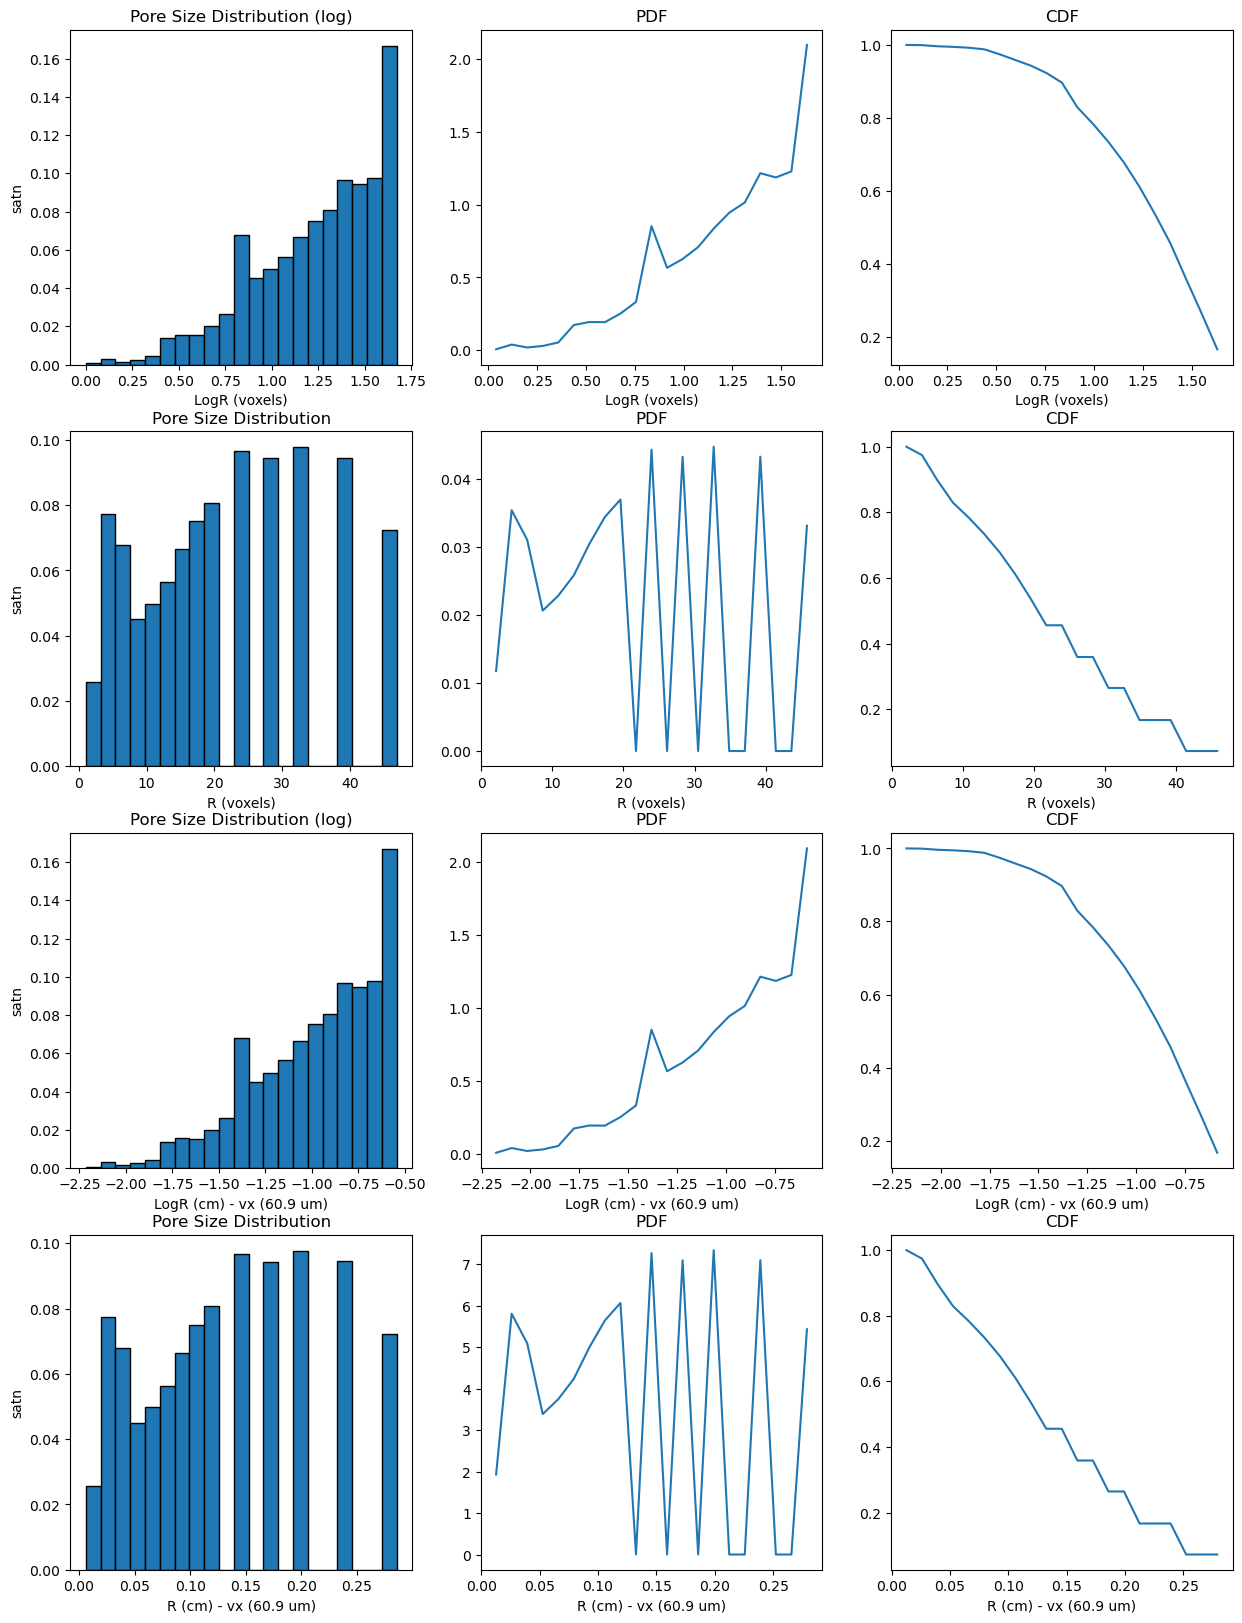

In [79]:
# Pore Size distribution
lt_ws_vx = lt_ws * vx_size * 100 #Voxel size in cm
bins = 21

fig, ax = plt.subplots(4,3,figsize=(15,20))

psd_ws_log = ps.metrics.pore_size_distribution(lt_ws, bins=bins, log=True)
ax[0,0].bar(psd_ws_log.LogR, psd_ws_log.satn, width=psd_ws_log.bin_widths, edgecolor='k'); ax[0,0].set_ylabel("satn"); ax[0,0].set_xlabel("LogR (voxels)"); ax[0,0].set_title('Pore Size Distribution (log)')
ax[0,1].plot(psd_ws_log.LogR, psd_ws_log.pdf); ax[0,1].set_title("PDF"); ax[0,1].set_xlabel("LogR (voxels)")
ax[0,2].plot(psd_ws_log.LogR, psd_ws_log.cdf); ax[0,2].set_title("CDF"); ax[0,2].set_xlabel("LogR (voxels)")

psd_ws = ps.metrics.pore_size_distribution(lt_ws, bins=bins, log=False)
ax[1,0].bar(psd_ws.R, psd_ws.satn, width=psd_ws.bin_widths, edgecolor='k'); ax[1,0].set_ylabel("satn"); ax[1,0].set_xlabel("R (voxels)"); ax[1,0].set_title('Pore Size Distribution')
ax[1,1].plot(psd_ws.R, psd_ws.pdf); ax[1,1].set_title("PDF"); ax[1,1].set_xlabel("R (voxels)")
ax[1,2].plot(psd_ws.R, psd_ws.cdf); ax[1,2].set_title("CDF"); ax[1,2].set_xlabel("R (voxels)")

psd_ws_vx_log = ps.metrics.pore_size_distribution(lt_ws_vx, bins=bins, log=True)
ax[2,0].bar(psd_ws_vx_log.LogR, psd_ws_vx_log.satn, width=psd_ws_vx_log.bin_widths, edgecolor='k'); ax[2,0].set_ylabel("satn"); ax[2,0].set_xlabel("LogR (cm) - vx (60.9 um)"); ax[2,0].set_title('Pore Size Distribution (log)')
ax[2,1].plot(psd_ws_vx_log.LogR, psd_ws_vx_log.pdf); ax[2,1].set_title("PDF"); ax[2,1].set_xlabel("LogR (cm) - vx (60.9 um)")
ax[2,2].plot(psd_ws_vx_log.LogR, psd_ws_vx_log.cdf); ax[2,2].set_title("CDF"); ax[2,2].set_xlabel("LogR (cm) - vx (60.9 um)")

psd_ws_vx = ps.metrics.pore_size_distribution(lt_ws_vx, bins=bins, log=False)
ax[3,0].bar(psd_ws_vx.R, psd_ws_vx.satn, width=psd_ws_vx.bin_widths, edgecolor='k'); ax[3,0].set_ylabel("satn"); ax[3,0].set_xlabel("R (cm) - vx (60.9 um)"); ax[3,0].set_title('Pore Size Distribution')
ax[3,1].plot(psd_ws_vx.R, psd_ws_vx.pdf); ax[3,1].set_title("PDF"); ax[3,1].set_xlabel("R (cm) - vx (60.9 um)")
ax[3,2].plot(psd_ws_vx.R, psd_ws_vx.cdf); ax[3,2].set_title("CDF"); ax[3,2].set_xlabel("R (cm) - vx (60.9 um)")

Text(0.5, 0, 'R (cm) - vx (60.9 um)')

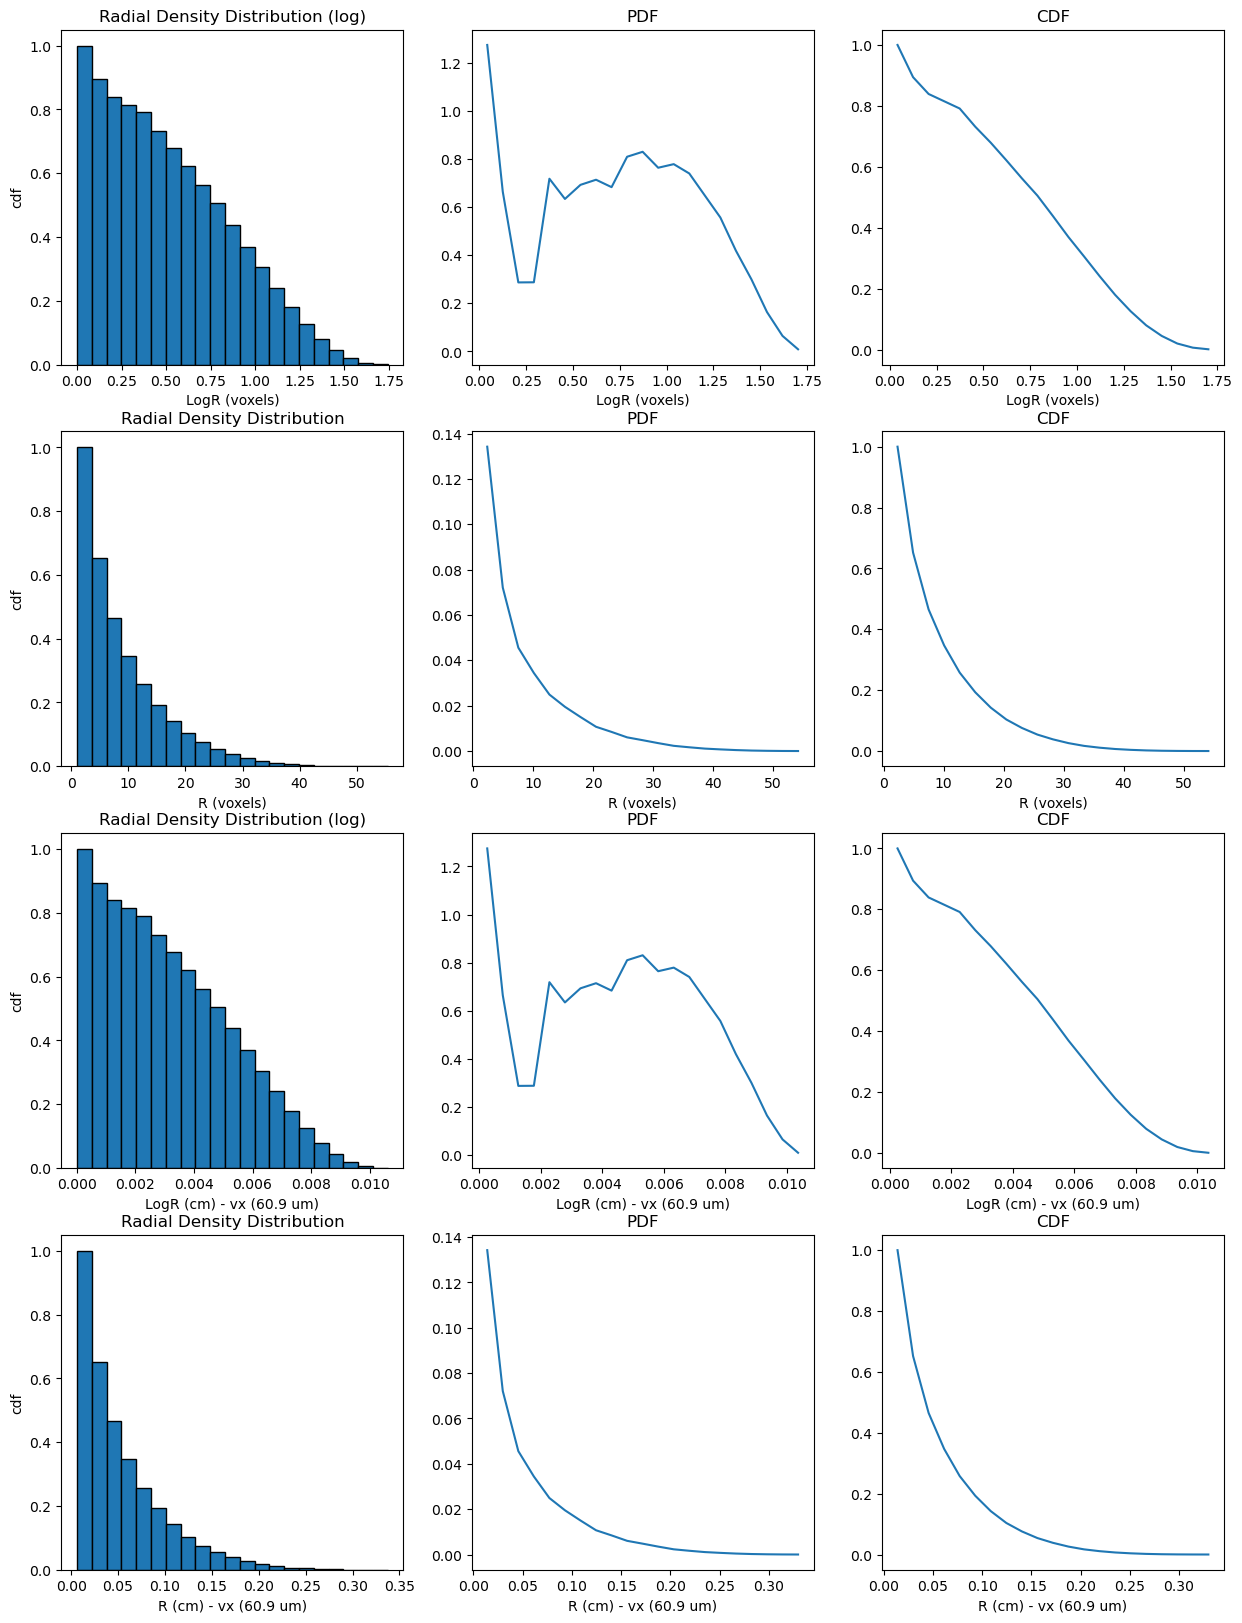

In [80]:
# Radial Density Distribution
fig, ax = plt.subplots(4,3,figsize=(15,20))

rdd_ws_log = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist, bins=bins, log=True)
ax[0,0].bar(rdd_ws_log.LogR, rdd_ws_log.cdf, width=rdd_ws_log.bin_widths, edgecolor='k'); ax[0,0].set_ylabel("cdf"); ax[0,0].set_xlabel("LogR (voxels)"); ax[0,0].set_title('Radial Density Distribution (log)')
ax[0,1].plot(rdd_ws_log.LogR, rdd_ws_log.pdf); ax[0,1].set_title("PDF"); ax[0,1].set_xlabel("LogR (voxels)")
ax[0,2].plot(rdd_ws_log.LogR, rdd_ws_log.cdf); ax[0,2].set_title("CDF"); ax[0,2].set_xlabel("LogR (voxels)")

rdd_ws = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist, bins=bins, log=False)
ax[1,0].bar(rdd_ws.R, rdd_ws.cdf, width=rdd_ws.bin_widths, edgecolor='k'); ax[1,0].set_ylabel("cdf"); ax[1,0].set_xlabel("R (voxels)"); ax[1,0].set_title('Radial Density Distribution')
ax[1,1].plot(rdd_ws.R, rdd_ws.pdf); ax[1,1].set_title("PDF"); ax[1,1].set_xlabel("R (voxels)")
ax[1,2].plot(rdd_ws.R, rdd_ws.cdf); ax[1,2].set_title("CDF"); ax[1,2].set_xlabel("R (voxels)")

rdd_ws_vx_log = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist, bins=bins, log=True, voxel_size=vx_size*100)
ax[2,0].bar(rdd_ws_vx_log.LogR, rdd_ws_vx_log.cdf, width=rdd_ws_vx_log.bin_widths, edgecolor='k'); ax[2,0].set_ylabel("cdf"); ax[2,0].set_xlabel("LogR (cm) - vx (60.9 um)"); ax[2,0].set_title('Radial Density Distribution (log)')
ax[2,1].plot(rdd_ws_vx_log.LogR, rdd_ws_vx_log.pdf); ax[2,1].set_title("PDF"); ax[2,1].set_xlabel("LogR (cm) - vx (60.9 um)")
ax[2,2].plot(rdd_ws_vx_log.LogR, rdd_ws_vx_log.cdf); ax[2,2].set_title("CDF"); ax[2,2].set_xlabel("LogR (cm) - vx (60.9 um)")

rdd_ws_vx = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist, bins=bins, log=False, voxel_size=vx_size*100)
ax[3,0].bar(rdd_ws_vx.R, rdd_ws_vx.cdf, width=rdd_ws_vx.bin_widths, edgecolor='k'); ax[3,0].set_ylabel("cdf"); ax[3,0].set_xlabel("R (cm) - vx (60.9 um)"); ax[3,0].set_title('Radial Density Distribution')
ax[3,1].plot(rdd_ws_vx.R, rdd_ws_vx.pdf); ax[3,1].set_title("PDF"); ax[3,1].set_xlabel("R (cm) - vx (60.9 um)")
ax[3,2].plot(rdd_ws_vx.R, rdd_ws_vx.cdf); ax[3,2].set_title("CDF"); ax[3,2].set_xlabel("R (cm) - vx (60.9 um)")

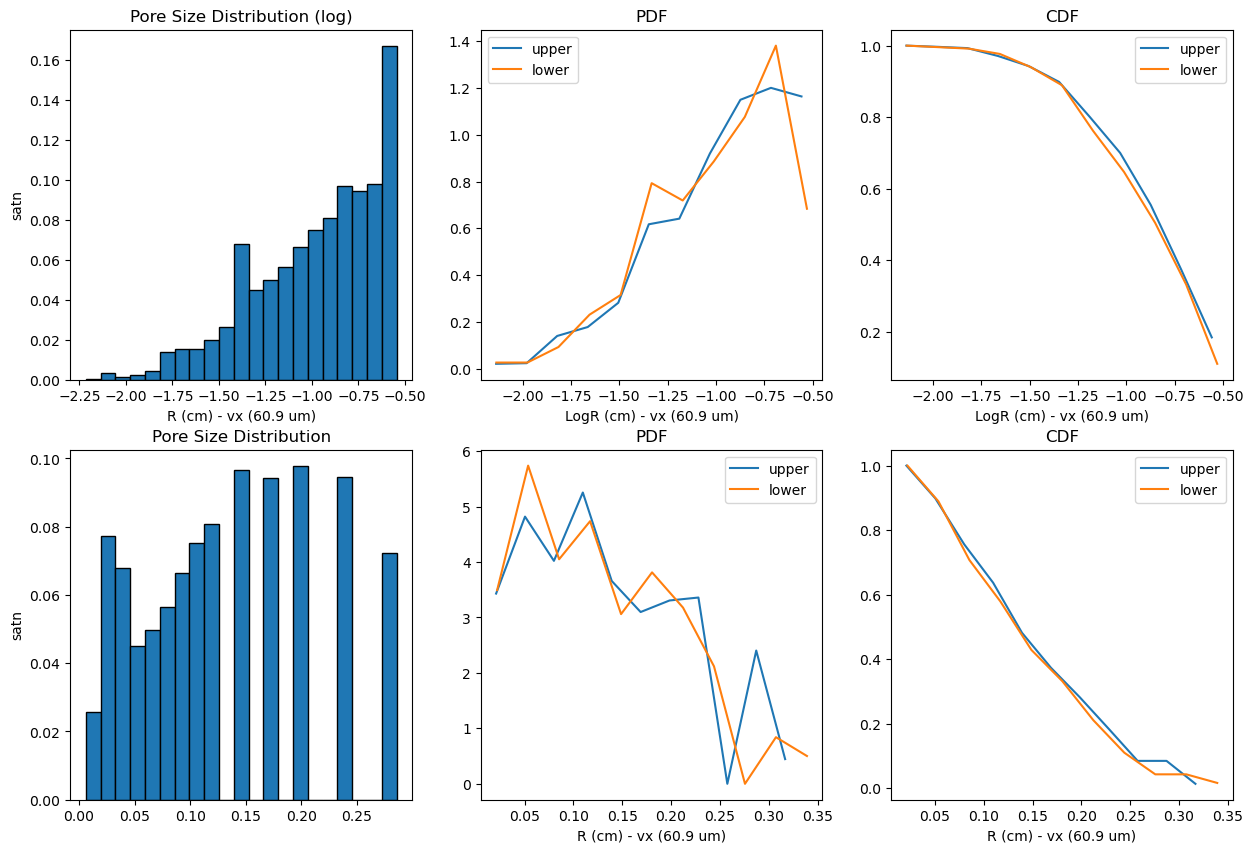

In [81]:
# Pore Size distribution
lt_ws_vx_upper = lt_ws_upper * vx_size * 100 #Voxel size in cm
lt_ws_vx_lower = lt_ws_lower * vx_size * 100 #Voxel size in cm
bins = 11

fig, ax = plt.subplots(2,3,figsize=(15,10))

psd_ws_vx_log_upper = ps.metrics.pore_size_distribution(lt_ws_vx_upper, bins=bins, log=True)
psd_ws_vx_log_lower = ps.metrics.pore_size_distribution(lt_ws_vx_lower, bins=bins, log=True)
ax[0,0].bar(psd_ws_vx_log.LogR, psd_ws_vx_log.satn, width=psd_ws_vx_log.bin_widths, edgecolor='k'); ax[0,0].set_ylabel("satn"); ax[0,0].set_xlabel("LogR (cm) - vx (60.9 um)"); ax[0,0].set_title('Pore Size Distribution (log)')
ax[0,1].plot(psd_ws_vx_log_upper.LogR, psd_ws_vx_log_upper.pdf, label = 'upper'); ax[0,1].set_title("PDF"); ax[0,1].set_xlabel("LogR (cm) - vx (60.9 um)")
ax[0,2].plot(psd_ws_vx_log_upper.LogR, psd_ws_vx_log_upper.cdf, label = 'upper'); ax[0,2].set_title("CDF"); ax[0,2].set_xlabel("LogR (cm) - vx (60.9 um)")
ax[0,1].plot(psd_ws_vx_log_lower.LogR, psd_ws_vx_log_lower.pdf, label = 'lower'); ax[0,1].legend()
ax[0,2].plot(psd_ws_vx_log_lower.LogR, psd_ws_vx_log_lower.cdf, label = 'lower'); ax[0,2].legend()

psd_ws_vx_upper = ps.metrics.pore_size_distribution(lt_ws_vx_upper, bins=bins, log=False)
psd_ws_vx_lower = ps.metrics.pore_size_distribution(lt_ws_vx_lower, bins=bins, log=False)
ax[1,0].bar(psd_ws_vx.R, psd_ws_vx.satn, width=psd_ws_vx.bin_widths, edgecolor='k'); ax[1,0].set_ylabel("satn"); ax[0,0].set_xlabel("R (cm) - vx (60.9 um)"); ax[1,0].set_title('Pore Size Distribution')
ax[1,1].plot(psd_ws_vx_upper.R, psd_ws_vx_upper.pdf, label = 'upper'); ax[1,1].set_title("PDF"); ax[1,1].set_xlabel("R (cm) - vx (60.9 um)")
ax[1,2].plot(psd_ws_vx_upper.R, psd_ws_vx_upper.cdf, label = 'upper'); ax[1,2].set_title("CDF"); ax[1,2].set_xlabel("R (cm) - vx (60.9 um)")
ax[1,1].plot(psd_ws_vx_lower.R, psd_ws_vx_lower.pdf, label = 'lower'); ax[1,1].legend()
ax[1,2].plot(psd_ws_vx_lower.R, psd_ws_vx_lower.cdf, label = 'lower'); ax[1,2].legend()

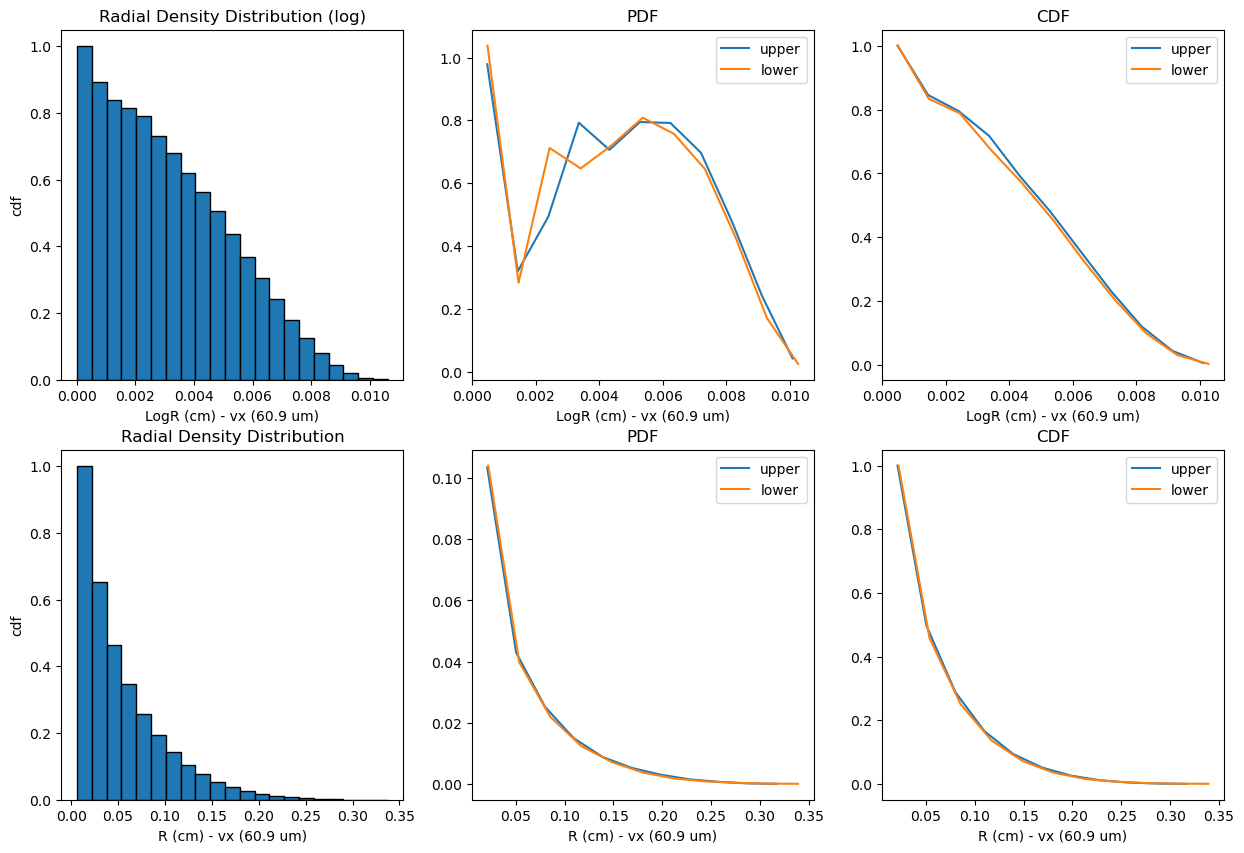

In [82]:
# Radial Density Distribution
fig, ax = plt.subplots(2,3,figsize=(15,10))

rdd_ws_vx_log_upper = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist_upper, bins=bins, log=True, voxel_size=vx_size*100)
rdd_ws_vx_log_lower = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist_lower, bins=bins, log=True, voxel_size=vx_size*100)
ax[0,0].bar(rdd_ws_vx_log.LogR, rdd_ws_vx_log.cdf, width=rdd_ws_vx_log.bin_widths, edgecolor='k'); ax[0,0].set_ylabel("cdf"); ax[0,0].set_xlabel("LogR (cm) - vx (60.9 um)"); ax[0,0].set_title('Radial Density Distribution (log)')
ax[0,1].plot(rdd_ws_vx_log_upper.LogR, rdd_ws_vx_log_upper.pdf, label = 'upper'); ax[0,1].set_title("PDF"); ax[0,1].set_xlabel("LogR (cm) - vx (60.9 um)")
ax[0,2].plot(rdd_ws_vx_log_upper.LogR, rdd_ws_vx_log_upper.cdf, label = 'upper'); ax[0,2].set_title("CDF"); ax[0,2].set_xlabel("LogR (cm) - vx (60.9 um)")
ax[0,1].plot(rdd_ws_vx_log_lower.LogR, rdd_ws_vx_log_lower.pdf, label = 'lower'); ax[0,1].legend()
ax[0,2].plot(rdd_ws_vx_log_lower.LogR, rdd_ws_vx_log_lower.cdf, label = 'lower'); ax[0,2].legend()
                                                       
rdd_ws_vx_upper = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist_upper, bins=bins, log=False, voxel_size=vx_size*100)
rdd_ws_vx_lower = ps.metrics.radial_density_distribution(dt=merged_labelled_image_ws_dist_lower, bins=bins, log=False, voxel_size=vx_size*100)                                
ax[1,0].bar(rdd_ws_vx.R, rdd_ws_vx.cdf, width=rdd_ws_vx.bin_widths, edgecolor='k'); ax[1,0].set_ylabel("cdf"); ax[1,0].set_xlabel("R (cm) - vx (60.9 um)"); ax[1,0].set_title('Radial Density Distribution')
ax[1,1].plot(rdd_ws_vx_upper.R, rdd_ws_vx_upper.pdf, label = 'upper'); ax[1,1].set_title("PDF"); ax[1,1].set_xlabel("R (cm) - vx (60.9 um)")
ax[1,2].plot(rdd_ws_vx_upper.R, rdd_ws_vx_upper.cdf, label = 'upper'); ax[1,2].set_title("CDF"); ax[1,2].set_xlabel("R (cm) - vx (60.9 um)")
ax[1,1].plot(rdd_ws_vx_lower.R, rdd_ws_vx_lower.pdf, label = 'lower'); ax[1,1].legend()
ax[1,2].plot(rdd_ws_vx_lower.R, rdd_ws_vx_lower.cdf, label = 'lower'); ax[1,2].legend()                                                       

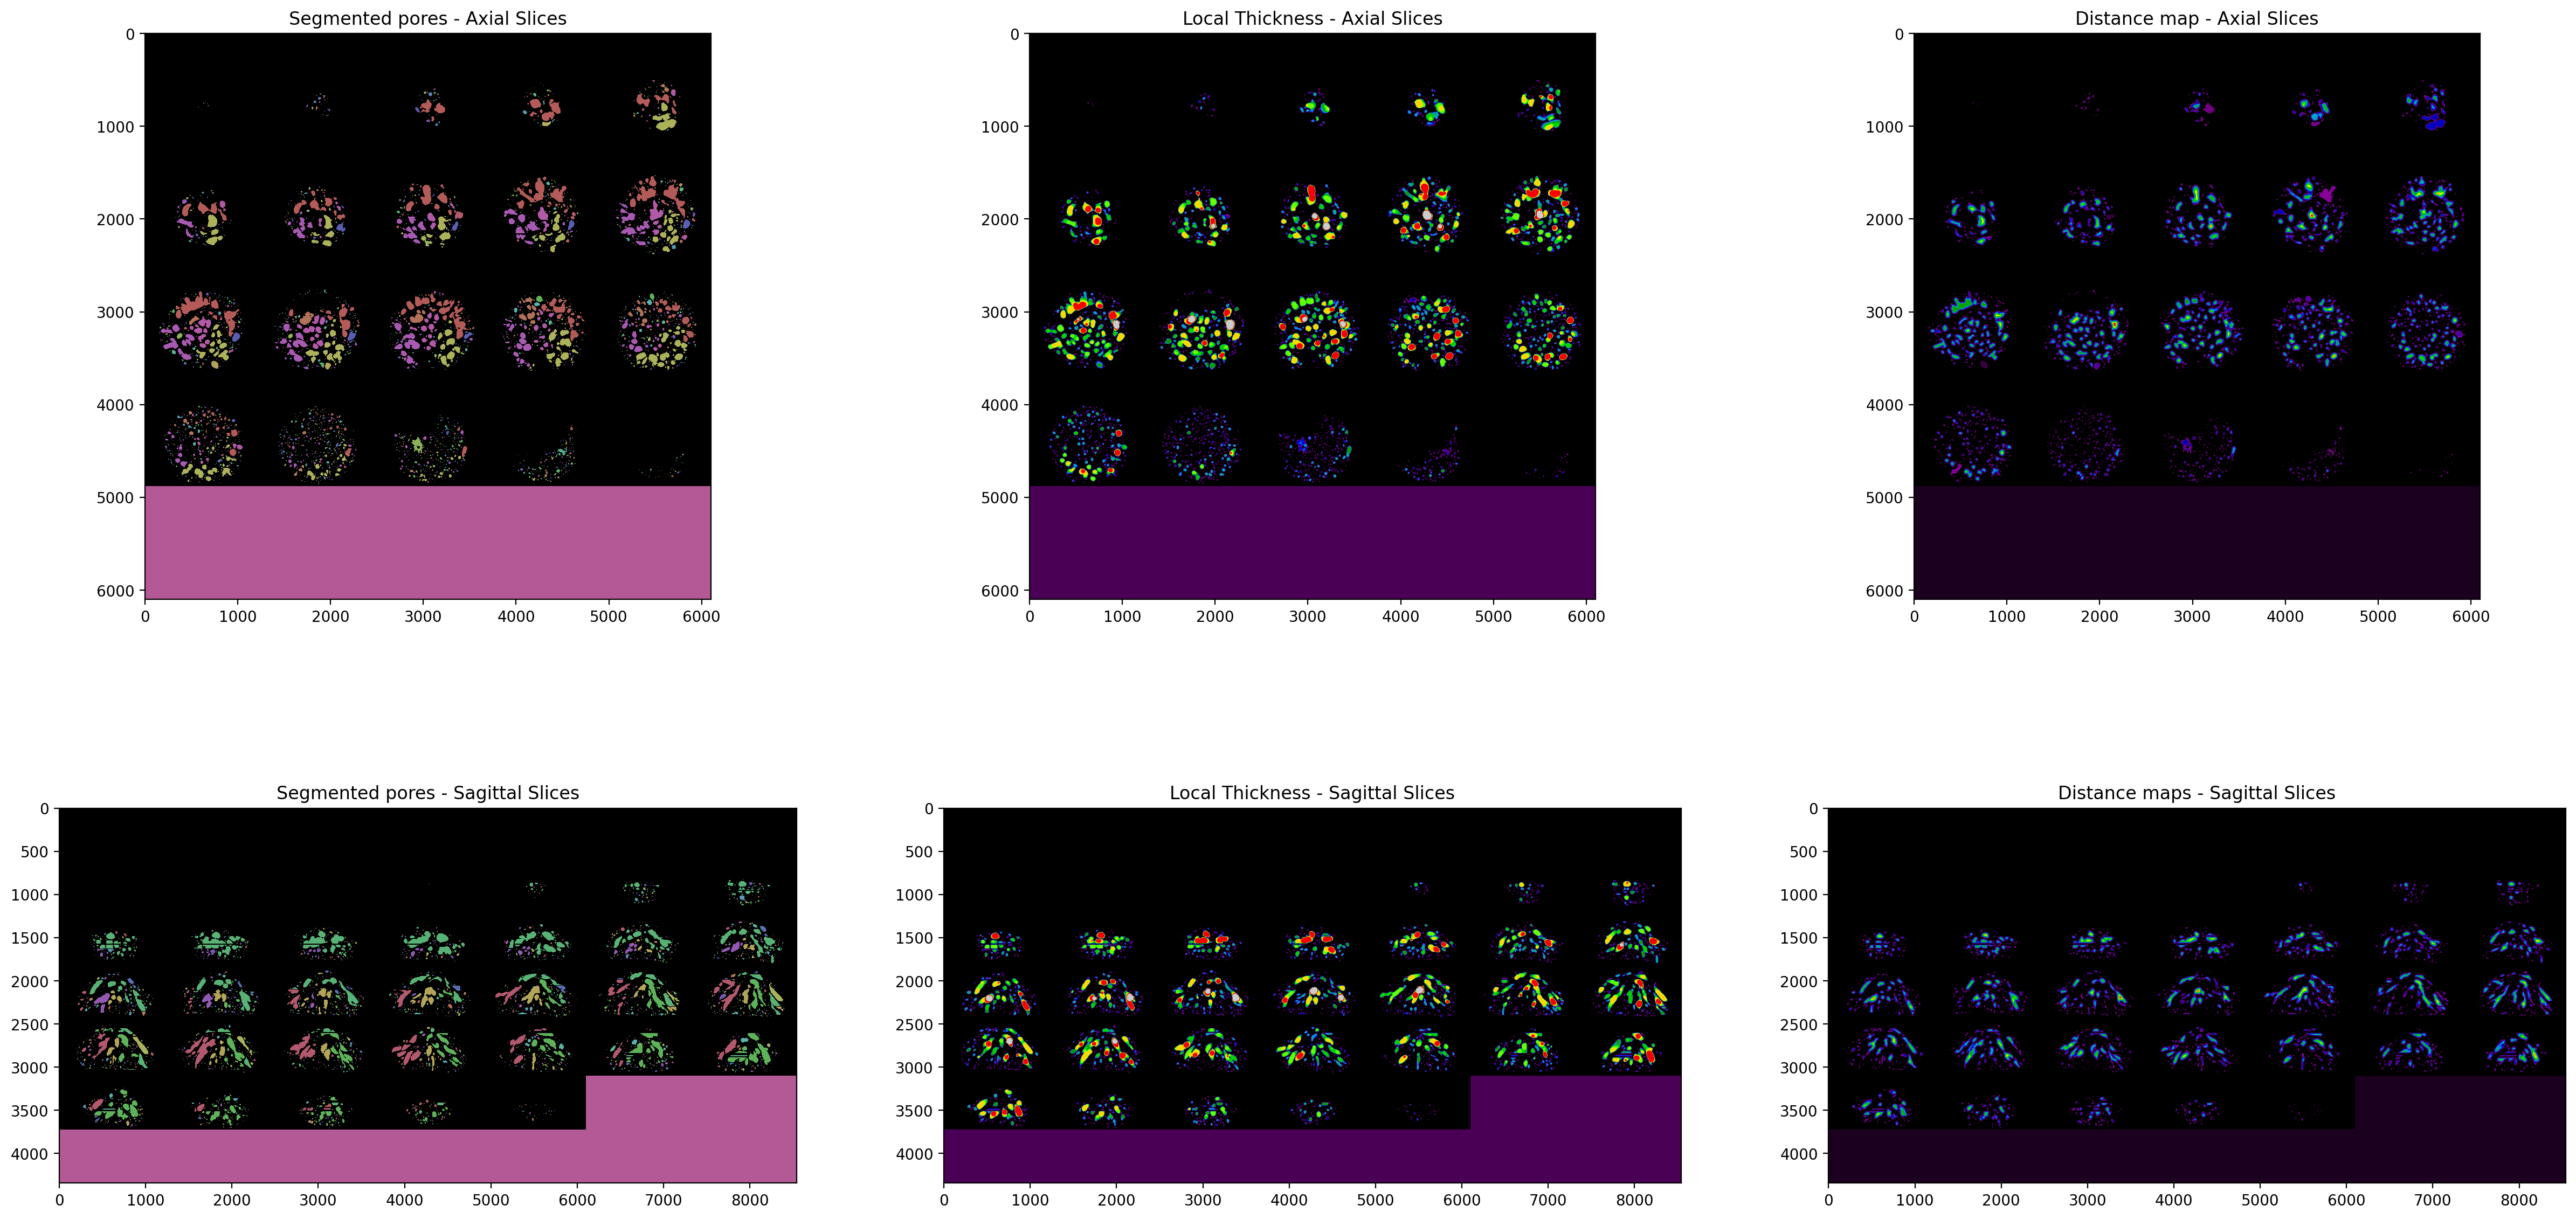

In [91]:
# Montage pad - original, segmented pores, distance
montage_pad = getattr(plots_plots_3d,"montage_pad")

fig, ax = plt.subplots(2, 3, figsize=(30,15),dpi=200)
ax[0,0].imshow(montage_pad(merged_labelled_image_ws[::30]), cmap=goldenCM(int(merged_labelled_image_lbl.max())),interpolation="None")
ax[0,0].set_title('Segmented pores - Axial Slices')
ax[0,2].imshow(montage_pad(merged_labelled_image_ws_dist[::30]), cmap='nipy_spectral')
ax[0,2].set_title('Distance map - Axial Slices')
ax[0,1].imshow(montage_pad(lt_ws_vx[::30]), cmap='nipy_spectral')
ax[0,1].set_title('Local Thickness - Axial Slices')

ax[1,0].imshow(montage_pad(merged_labelled_image_ws.swapaxes(
    0, 1)[::30]), cmap=goldenCM(int(merged_labelled_image_lbl.max())),interpolation="None")
ax[1,0].set_title('Segmented pores - Sagittal Slices');
ax[1,2].imshow(montage_pad(merged_labelled_image_ws_dist.swapaxes(0, 1)[::30]), cmap='nipy_spectral')
ax[1,2].set_title('Distance maps - Sagittal Slices');
ax[1,1].imshow(montage_pad(lt_ws_vx.swapaxes(0, 1)[::30]), cmap='nipy_spectral')
ax[1,1].set_title('Local Thickness - Sagittal Slices');
    

In [ ]:
# 3d plot

In [82]:
del img
del connthresh_medfilter3_ds_img_1
del filled_pores_1
if invert_flag ==1:
    del inverted_image_1
del merged_labelled_image_lbl
del merged_labelled_image_ws
del lt_ws

In [92]:
psd_vx_log_dict_pdf[bread_type] = psd_ws_vx_log.pdf
psd_vx_log_dict_cdf[bread_type] = psd_ws_vx_log.cdf

rdd_vx_log_dict_pdf[bread_type] = rdd_ws_vx_log.pdf
rdd_vx_log_dict_cdf[bread_type] = rdd_ws_vx_log.cdf

In [61]:
psd_vx_log_dict_pdf_upper[bread_type] = psd_ws_vx_log_upper.pdf
psd_vx_log_dict_cdf_upper[bread_type] = psd_ws_vx_log_upper.cdf

rdd_vx_log_dict_pdf_upper[bread_type] = rdd_ws_vx_upper.pdf
rdd_vx_log_dict_cdf_upper[bread_type] = rdd_ws_vx_upper.cdf

psd_vx_log_dict_pdf_lower[bread_type] = psd_ws_vx_log_lower.pdf
psd_vx_log_dict_cdf_lower[bread_type] = psd_ws_vx_log_lower.cdf

rdd_vx_log_dict_pdf_lower[bread_type] = rdd_ws_vx_lower.cdf
rdd_vx_log_dict_cdf_lower[bread_type] = rdd_ws_vx_lower.cdf

In [ ]:
psd_vx_log_dict_pdf

In [ ]:
# The following part requires 2 or more distributions in the above dictionaries
# 2 or more samples (bread types)

In [114]:
kl_divergence = getattr(pores_rdd_psd_dist_comparison,"kl_divergence")
ks_test = getattr(pores_rdd_psd_dist_comparison,"ks_test")
calculate_pairwise_metrics = getattr(pores_rdd_psd_dist_comparison,"calculate_pairwise_metrics")
plot_heatmaps = getattr(pores_rdd_psd_dist_comparison,"plot_heatmaps")

In [108]:
# Calculate pairwise KS statistics for PDFs
kl_divergences_psd, _, sample_names = calculate_pairwise_metrics(psd_vx_log_dict_pdf, lambda x, y: (kl_divergence(x, y), 0))
kl_divergences_rdd, _, _ = calculate_pairwise_metrics(rdd_vx_log_dict_pdf, lambda x, y: (kl_divergence(x, y), 0))

# Calculate pairwise KS statistics and p-values for CDFs
ks_statistics_psd, ks_pvalues_psd, _ = calculate_pairwise_metrics(psd_vx_log_dict_cdf, ks_test)
ks_statistics_rdd, ks_pvalues_rdd, _ = calculate_pairwise_metrics(rdd_vx_log_dict_cdf, ks_test)

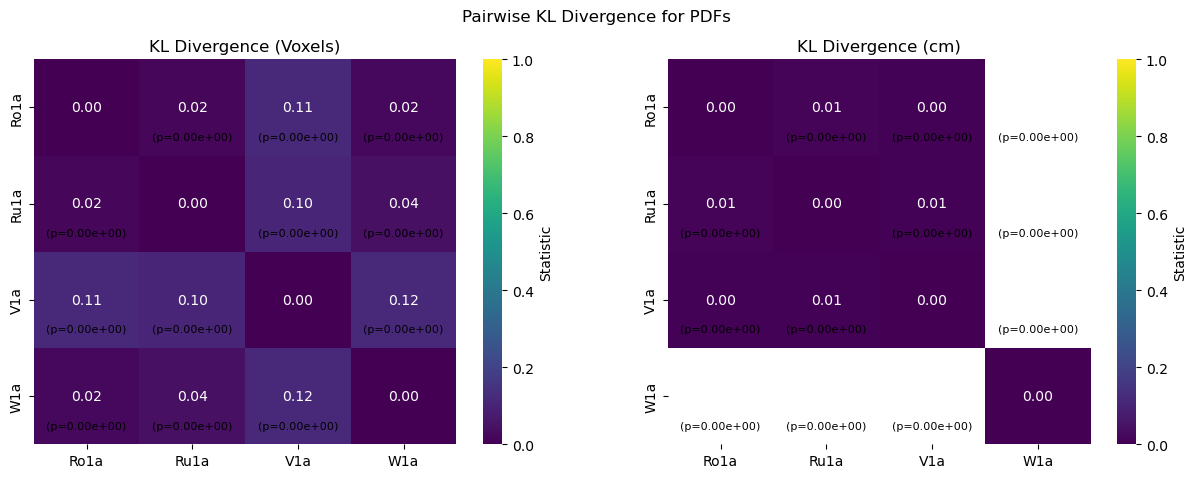

In [115]:
# Plot pairwise KL divergences for PDFs
plot_heatmaps(
    [kl_divergences_psd, kl_divergences_rdd],
    [np.zeros_like(kl_divergences_psd), np.zeros_like(kl_divergences_rdd)],  # No p-values for KL divergence
    ["KL Divergence (Voxels)", "KL Divergence (cm)"],
    sample_names,
    "Pairwise KL Divergence for PDFs"
)

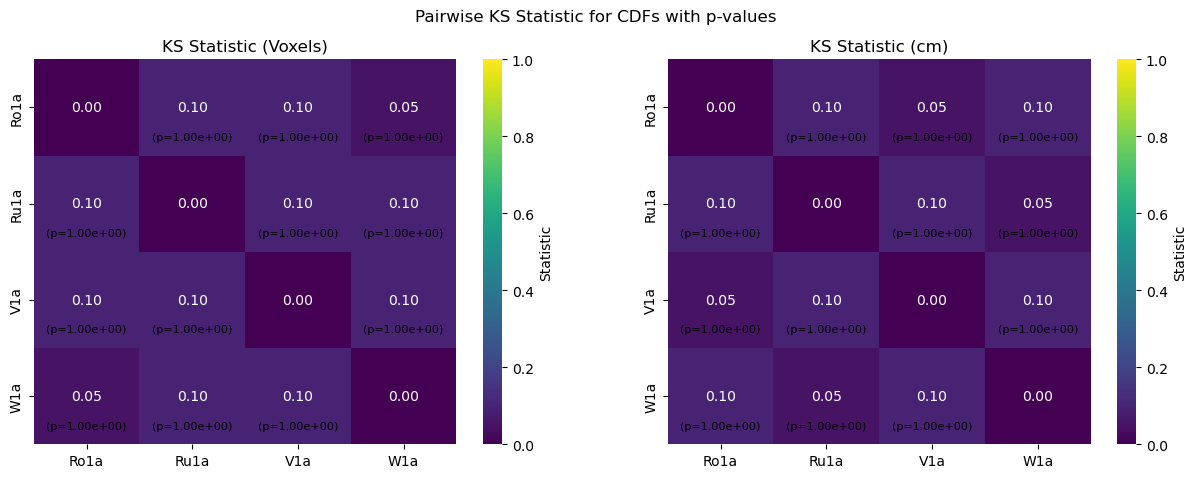

In [116]:
# Plot pairwise KS statistics for CDFs with p-values
plot_heatmaps(
    [ks_statistics_psd, ks_statistics_rdd],
    [ks_pvalues_psd, ks_pvalues_rdd],
    ["KS Statistic (Voxels)", "KS Statistic (cm)"],
    sample_names,
    "Pairwise KS Statistic for CDFs with p-values"
)

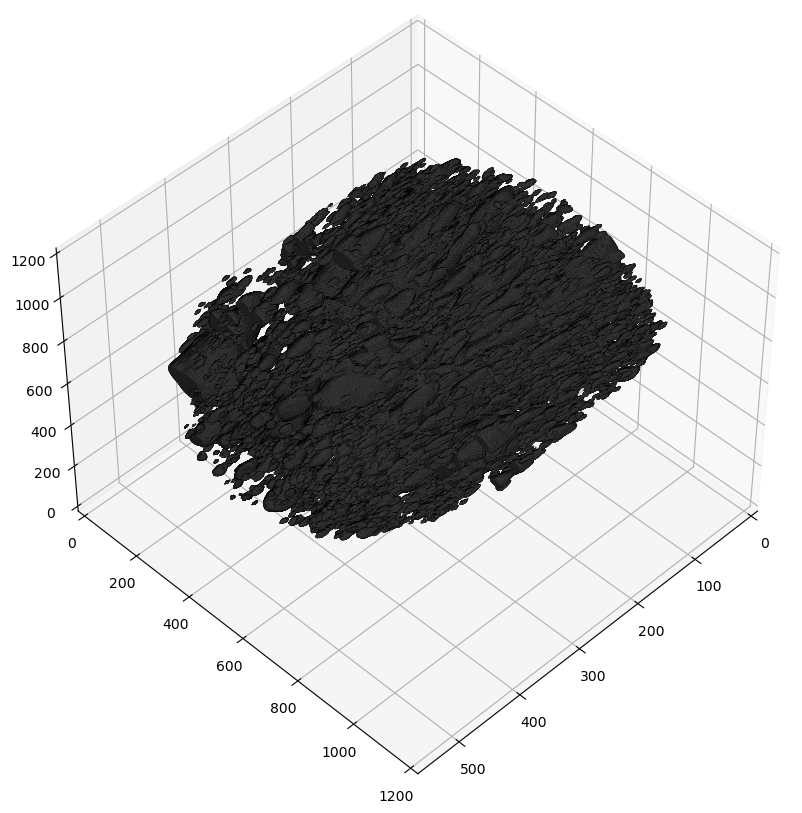

In [87]:
interactive_3d = getattr(plots_plots_3d,"interactive_3d")
show_3d_mesh = getattr(plots_plots_3d,"show_3d_mesh")

#interactive_3d(merged_labelled_image_ws)

show_3d_mesh(merged_labelled_image_ws, [merged_labelled_image_ws.mean()],
             alpha=0.75, edgecolor='black');